# Part5: 建構 GNN model
實作 Cora 資料集結點分類任務

https://karenkaods.medium.com/邁向圖神經網絡gnn-part5-建構-gnn-model-實作-cora-資料集結點分類任務-6cdac24e7fbf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt

從 torch 下載 Cora 資料集

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Cora 資料集是一個常用於圖神經網絡 (Graph Neural Networks, GNN) 研究的標準數據集。它主要包含機器學習領域的科學論文，這些論文被分類成七個類別，如神經網絡、機器學習、人工智能等。Cora 數據集的主要特點和組成如下：

1. 節點：每個節點代表一篇科學論文。
2. 邊：如果一篇論文引用了另一篇論文，則這兩篇論文之間存在一條邊。這種表示方式將論文集結成一個引用網絡。
3. 特徵：每個節點（論文）都有一個對應的特徵向量，這個特徵向量是基於論文的單詞使用情況的稀疏二進制向量。特徵向量的每一維表示一個單詞是否在該論文中出現。
4. 類別：每篇論文都被標註為七個領域中的一種，例如：人工智能、神經網絡、機器學習… 等。

使用這個資料集可以進行分類任務檢測: 輸入節點與關係和其特徵，預測分類該論文為哪一類別。

## Cora 資料集簡單資料觀察

In [3]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0]  # Get the first graph object.

print()
print(graph)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Number of training nodes: {graph.train_mask.sum()}')
print(f'Training node label rate: {int(graph.train_mask.sum()) / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


1. 圖的數量：數據集中只有一個圖。在這種情況下，整個數據集是一個大的圖，其中節點表示科學論文，邊表示論文間的引用關係。

2. 特徵數量：每個節點（論文）都有1433個特徵。這些特徵是基於文本內容的二進制向量，代表了1433個不同的單詞是否出現在該論文中。

3. 類別數量：有7個不同的類別，每個類別代表論文所屬的科學領域。

4. 節點和邊的數量：
    - 節點數量：2708，表示有2708篇科學論文。
    - 邊的數量：10556，表示這些論文間共有10556次引用。

5. 平均節點度數：約3.90，這表明每篇論文平均被其他論文引用了3.90次。

6. 訓練節點：
    - 訓練節點數量：140，這表示只有140篇論文的類別標籤會用於訓練模型。
    - 訓練節點標籤比率：約0.05，即大約5%的論文用於訓練，這是一個相對較少的比例，表明大部分數據用於驗證和測試。

7. 其他圖特性：
    - 是否有孤立節點：False，表示所有節點至少與一個其他節點有連接。
    - 是否有自循環：False，表示沒有任何節點指向自己的邊。
    - 是否為無向圖：True，這表示引用關係被視為雙向的，即如果節點A引用節點B，那麼從節點B到節點A也被認為存在一個邊。


## 實作 GNN model

In [4]:
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv

class myGNN(torch.nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim, aggr='mean', **kwargs):
        super(myGNN, self).__init__()
        self.layer_num = layer_num

        self.encoder = nn.Linear(input_dim, hidden_dim)

        # you can use the message passing layer you like, such as GCN, GAT, ......
        # self.mp_layer = NN_MessagePassingLayer(input_dim=hidden_dim, hidden_dim=hidden_dim,
        #                                        output_dim=hidden_dim, aggr=aggr)

        self.mp_layer = GCNConv(hidden_dim, hidden_dim, aggr=aggr)

        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.encoder(x)
        for i in range(self.layer_num):
            x = self.mp_layer(x, edge_index)
        node_out = self.decoder(x)
        return node_out

In [5]:
import torch.optim as optim

# 初始化模型和優化器
model = myGNN(layer_num=2, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [6]:
# 定義訓練函數
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(graph.x, graph.edge_index)  # Perform a single forward pass.
    loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

# 定義測試函數
def test():
    model.eval()
    out = model(graph.x, graph.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

# 訓練和測試循環
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9526
Epoch: 002, Loss: 1.9508
Epoch: 003, Loss: 1.9493
Epoch: 004, Loss: 1.9480
Epoch: 005, Loss: 1.9469
Epoch: 006, Loss: 1.9462
Epoch: 007, Loss: 1.9456
Epoch: 008, Loss: 1.9453
Epoch: 009, Loss: 1.9450
Epoch: 010, Loss: 1.9448
Epoch: 011, Loss: 1.9445
Epoch: 012, Loss: 1.9442
Epoch: 013, Loss: 1.9438
Epoch: 014, Loss: 1.9432
Epoch: 015, Loss: 1.9425
Epoch: 016, Loss: 1.9415
Epoch: 017, Loss: 1.9404
Epoch: 018, Loss: 1.9389
Epoch: 019, Loss: 1.9371
Epoch: 020, Loss: 1.9348
Epoch: 021, Loss: 1.9320
Epoch: 022, Loss: 1.9286
Epoch: 023, Loss: 1.9245
Epoch: 024, Loss: 1.9198
Epoch: 025, Loss: 1.9147
Epoch: 026, Loss: 1.9094
Epoch: 027, Loss: 1.9039
Epoch: 028, Loss: 1.8973
Epoch: 029, Loss: 1.8894
Epoch: 030, Loss: 1.8801
Epoch: 031, Loss: 1.8692
Epoch: 032, Loss: 1.8566
Epoch: 033, Loss: 1.8418
Epoch: 034, Loss: 1.8244
Epoch: 035, Loss: 1.8041
Epoch: 036, Loss: 1.7814
Epoch: 037, Loss: 1.7567
Epoch: 038, Loss: 1.7308
Epoch: 039, Loss: 1.7034
Epoch: 040, Loss: 1.6744


# t-SNE 可視化

t-SNE 是一種用於高維數據降維的技術，它可以將高維數據映射到二維或三維空間，以便我們可以更容易地對數據進行可視化。在這裡，我們將使用 t-SNE 將節點的特徵向量映射到二維空間，以便我們可以在二維平面上可視化節點。

In [7]:
from sklearn.manifold import TSNE

def visualize(h, color):
    # Apply t-SNE
    tsne = TSNE(n_components=2)
    h_tsne = tsne.fit_transform(h)

    # Visualize the t-SNE output
    color = graph.y.detach().cpu().numpy()

    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(h_tsne[:, 0], h_tsne[:, 1], s=140, c=color, cmap="Set2")
    plt.show()

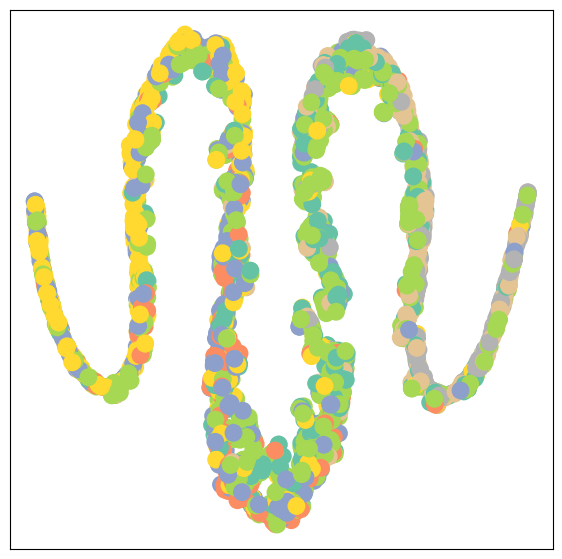

In [8]:
# 可視化輸出
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out.detach().cpu().numpy(), color=graph.y)

## Improve performance

- 增加 Batch Normalization : 讓訊息傳遞層因為有 normalize ，傳遞更穩定，模型也盡快收斂
- 獨立的訊息傳遞層與 modulize : 原本的方法是，單一的訊息傳遞層多次重複使用，調整後每個會是獨立的，允許每層學習到不同的權重與特徵。

In [12]:
class myGNN(torch.nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim, aggr='mean'):
        super(myGNN, self).__init__()
        self.layer_num = layer_num
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(layer_num)])
        self.mp_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim, aggr=aggr) for _ in range(layer_num)])
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.encoder(x)
        for i in range(self.layer_num):
            x = self.mp_layers[i](x, edge_index)
            x = F.relu(x)
            x = self.bn_layers[i](x)
        x = self.decoder(x)
        return x

In [13]:
# 初始化模型和優化器
model = myGNN(layer_num=2, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 訓練和測試循環
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9566
Epoch: 002, Loss: 1.8235
Epoch: 003, Loss: 1.5573
Epoch: 004, Loss: 1.3913
Epoch: 005, Loss: 1.3122
Epoch: 006, Loss: 1.1667
Epoch: 007, Loss: 1.0832
Epoch: 008, Loss: 0.9994
Epoch: 009, Loss: 0.9105
Epoch: 010, Loss: 0.8302
Epoch: 011, Loss: 0.7654
Epoch: 012, Loss: 0.7041
Epoch: 013, Loss: 0.6450
Epoch: 014, Loss: 0.5900
Epoch: 015, Loss: 0.5378
Epoch: 016, Loss: 0.4890
Epoch: 017, Loss: 0.4415
Epoch: 018, Loss: 0.3981
Epoch: 019, Loss: 0.3573
Epoch: 020, Loss: 0.3197
Epoch: 021, Loss: 0.2859
Epoch: 022, Loss: 0.2549
Epoch: 023, Loss: 0.2265
Epoch: 024, Loss: 0.2011
Epoch: 025, Loss: 0.1782
Epoch: 026, Loss: 0.1576
Epoch: 027, Loss: 0.1391
Epoch: 028, Loss: 0.1231
Epoch: 029, Loss: 0.1085
Epoch: 030, Loss: 0.0954
Epoch: 031, Loss: 0.0837
Epoch: 032, Loss: 0.0732
Epoch: 033, Loss: 0.0637
Epoch: 034, Loss: 0.0554
Epoch: 035, Loss: 0.0482
Epoch: 036, Loss: 0.0419
Epoch: 037, Loss: 0.0364
Epoch: 038, Loss: 0.0317
Epoch: 039, Loss: 0.0275
Epoch: 040, Loss: 0.0240


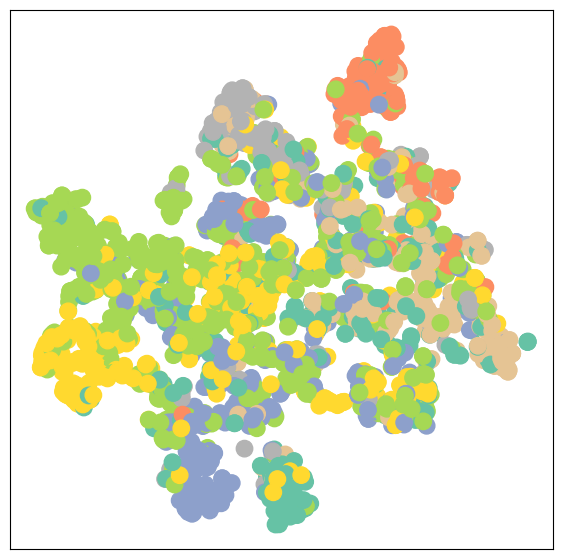

In [14]:
# 可視化輸出
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out.detach().cpu().numpy(), color=graph.y)

訓練過程中 loss 有下降，但在 test case 表現不佳，僅 0.3560 ，是 overfitting 的現象，那我們再增加 dropout 去調整

In [15]:
class myGNN(torch.nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim, dropout_rate=0.55, aggr='mean'):
        super(myGNN, self).__init__()
        self.layer_num = layer_num
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(layer_num)])
        self.mp_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim, aggr=aggr) for _ in range(layer_num)])
        self.dropout = dropout_rate
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.encoder(x)
        for i in range(self.layer_num):
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.bn_layers[i](x)
            x = self.mp_layers[i](x, edge_index)
        x = self.decoder(x)
        return x

In [16]:
# 初始化模型和優化器
model = myGNN(layer_num=2, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 訓練和測試循環
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9471
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9119
Epoch: 004, Loss: 1.8846
Epoch: 005, Loss: 1.8682
Epoch: 006, Loss: 1.7899
Epoch: 007, Loss: 1.7463
Epoch: 008, Loss: 1.7735
Epoch: 009, Loss: 1.7091
Epoch: 010, Loss: 1.7039
Epoch: 011, Loss: 1.6443
Epoch: 012, Loss: 1.5843
Epoch: 013, Loss: 1.5921
Epoch: 014, Loss: 1.5490
Epoch: 015, Loss: 1.5003
Epoch: 016, Loss: 1.4792
Epoch: 017, Loss: 1.4140
Epoch: 018, Loss: 1.4070
Epoch: 019, Loss: 1.3966
Epoch: 020, Loss: 1.3350
Epoch: 021, Loss: 1.3239
Epoch: 022, Loss: 1.3146
Epoch: 023, Loss: 1.2610
Epoch: 024, Loss: 1.2354
Epoch: 025, Loss: 1.2068
Epoch: 026, Loss: 1.1750
Epoch: 027, Loss: 1.2334
Epoch: 028, Loss: 1.1033
Epoch: 029, Loss: 1.1384
Epoch: 030, Loss: 1.0316
Epoch: 031, Loss: 1.0716
Epoch: 032, Loss: 1.0919
Epoch: 033, Loss: 0.9855
Epoch: 034, Loss: 1.0539
Epoch: 035, Loss: 0.9062
Epoch: 036, Loss: 0.9008
Epoch: 037, Loss: 0.9747
Epoch: 038, Loss: 0.8789
Epoch: 039, Loss: 0.8480
Epoch: 040, Loss: 0.9020


Test acc 有明顯的提升到 0.4660

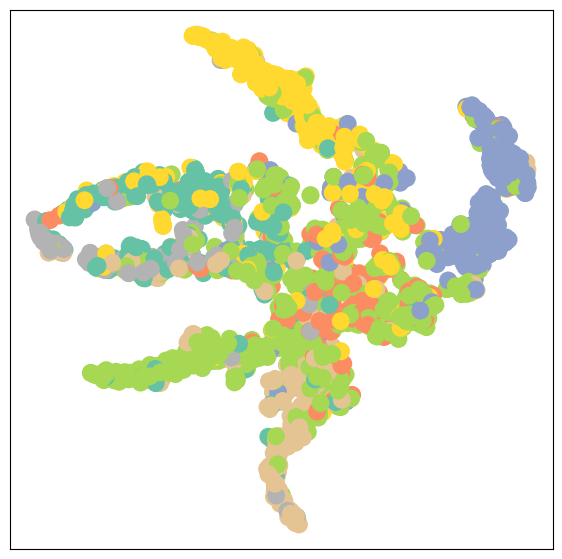

In [17]:
# 可視化輸出
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out.detach().cpu().numpy(), color=graph.y)

有提到關於 node update 之前 agg 的方法，add 的表現大多會優於 mean 與 max ，因此我們這裡也改成 add ，同時 dropout 再提升 0.05

In [19]:
class myGNN(torch.nn.Module):
    def __init__(self, layer_num, input_dim, hidden_dim, output_dim, dropout_rate=0.6, aggr='add'):
        super(myGNN, self).__init__()
        self.layer_num = layer_num
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(layer_num)])
        self.mp_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim, aggr=aggr) for _ in range(layer_num)])
        self.dropout = dropout_rate
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.encoder(x)
        for i in range(self.layer_num):
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.bn_layers[i](x)
            x = self.mp_layers[i](x, edge_index)
        x = self.decoder(x)
        return x


In [20]:
# 初始化模型和優化器
model = myGNN(layer_num=2, input_dim=dataset.num_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# 訓練和測試循環
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 2.1091
Epoch: 002, Loss: 1.9262
Epoch: 003, Loss: 1.8656
Epoch: 004, Loss: 1.7867
Epoch: 005, Loss: 1.6481
Epoch: 006, Loss: 1.5758
Epoch: 007, Loss: 1.4162
Epoch: 008, Loss: 1.3192
Epoch: 009, Loss: 1.3104
Epoch: 010, Loss: 1.1884
Epoch: 011, Loss: 1.1355
Epoch: 012, Loss: 1.0184
Epoch: 013, Loss: 0.8959
Epoch: 014, Loss: 0.8748
Epoch: 015, Loss: 0.8488
Epoch: 016, Loss: 0.7712
Epoch: 017, Loss: 0.6187
Epoch: 018, Loss: 0.6068
Epoch: 019, Loss: 0.5771
Epoch: 020, Loss: 0.5625
Epoch: 021, Loss: 0.5087
Epoch: 022, Loss: 0.4620
Epoch: 023, Loss: 0.5241
Epoch: 024, Loss: 0.4111
Epoch: 025, Loss: 0.3769
Epoch: 026, Loss: 0.3581
Epoch: 027, Loss: 0.2895
Epoch: 028, Loss: 0.2740
Epoch: 029, Loss: 0.3087
Epoch: 030, Loss: 0.3829
Epoch: 031, Loss: 0.3412
Epoch: 032, Loss: 0.2635
Epoch: 033, Loss: 0.2773
Epoch: 034, Loss: 0.3432
Epoch: 035, Loss: 0.3843
Epoch: 036, Loss: 0.2499
Epoch: 037, Loss: 0.2654
Epoch: 038, Loss: 0.3158
Epoch: 039, Loss: 0.2744
Epoch: 040, Loss: 0.2256


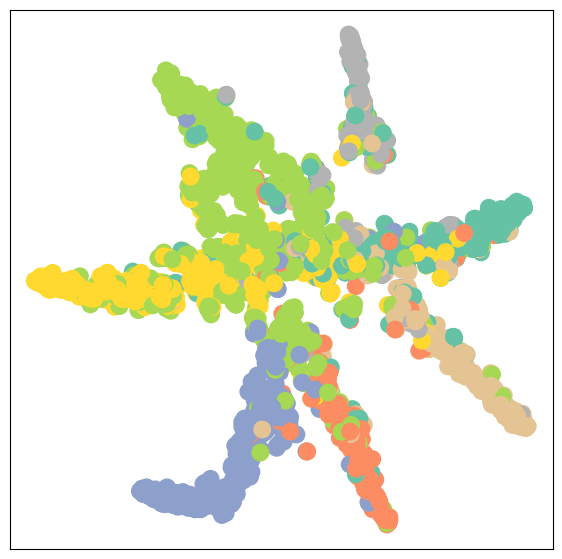

In [21]:
# 可視化輸出
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out.detach().cpu().numpy(), color=graph.y)

Test acc 明顯提升到 0.7 ，同時可視化效果每一個類別更加分散，還是有零星分錯類別，不過作為 baseline model ，結果顯示 GNN 是有效的。

## 小結

今天我們討論了如何使用 PyTorch 框架來構建和訓練圖神經網絡（GNN），並使用 Cora 資料集進行節點分類任務。透過逐步改進模型架構，包括引入批量標準化和獨立的消息傳遞層，以及調整 Dropout 和聚合函數，我們顯著提高了模型的分類準確率。最終實驗表明，經過優化的 GNN 模型在處理圖結構數據上具有強大的性能和應用潛力~我們下篇見！